In [4]:
# from sklearn.datasets import make_multilabel_classification
from torch.utils.data import Dataset
from NN_Models import LogisticRegressionSplit
from preprocessing import for_kaggle

import json
import numpy as np
import pandas as pd
import torch
import time
from tqdm import tqdm

In [2]:
# f = open("outputs/year_venue_naive_bayes.json", 'r')
f = open("outputs/year_venue.json", 'r')
year_venue = json.load(f)

f = open("outputs/abstract_title.json", 'r')
abstracts_title = json.load(f)

f = open("outputs/author.json", 'r')
author = json.load(f)

## Weighted

In [3]:
#################################
weight_sentence = 0.34228285295777994  # abstracts - title
weight_author = 0.6230497116557763  # authors
weight_year_venue = 0.09389756213513412  # year - venue

sum_ = weight_author + weight_sentence + weight_year_venue
#################################

YEAR_VENUE_WEIGHT = weight_year_venue/sum_
COAUTHOR_WEIGHT = weight_author/sum_
SENTENCE_WEIGHT = weight_sentence/sum_

def get_weighted_value(i, j):
    val1 = year_venue[i][j] * YEAR_VENUE_WEIGHT
    val2 = author[i][j] * COAUTHOR_WEIGHT
    val3 = abstracts_title[i][j] * SENTENCE_WEIGHT
    
    return val1 + val2 + val3
    

In [25]:
p = 0.20250

X_kaggle = for_kaggle('coauthor', type='numpy')
has_author_dict = LogisticRegressionSplit(X_kaggle, p=p)

delet some useless data: 100%|██████████| 25793/25793 [00:00<00:00, 67264.90it/s]


Number of instance with label :  7460
Number of instance without label(remain) :  1894


authors: 100%|██████████| 25793/25793 [00:04<00:00, 5941.14it/s]


Accuracy of split (prolific authors) & (no prolific authors)  :  0.9181098995082317


In [26]:
len(has_author_dict['no_pauthor']) + len(has_author_dict['have_pauthor'])

800

In [27]:
THRESHOLD = 0.2

kaggle_predict = []

for i in range(800):
    if i in has_author_dict['no_pauthor']:
        kaggle_predict.append('-1')
        continue
    
    pred = ""
    
    for j in range(100):
        
        val = get_weighted_value(str(i), str(j))
        
        if val >= THRESHOLD:
            pred += str(j) + " "

    if pred:
        kaggle_predict.append(pred[:-1])
    else:
        kaggle_predict.append("-1")

        

In [28]:
kaggle = pd.DataFrame(columns=["ID", "Predict"])
kaggle['Predict'] = kaggle_predict
kaggle['ID'] = kaggle.index
kaggle = kaggle.set_index('ID')
kaggle.to_csv("../../kaggle/predict_weighted_messi.csv")

## Election

In [55]:
THRESHOLD_YV = 0.4
THRESHOLD_AU = 0.6
THRESHOLD_AT = 0.2

kaggle_predict = []

for i in range(800):
    
    preds_dict = {}
    
    for j in range(100):

        # year & venue
        yv = year_venue[str(i)][str(j)]
        
        if yv >= THRESHOLD_YV:
            if j in preds_dict:
                preds_dict[j] += 1
            else:
                preds_dict[j] = 1

        # author
        au = author[str(i)][str(j)]
        
        if au >= THRESHOLD_AU:
            if j in preds_dict:
                preds_dict[j] += 1
            else:
                preds_dict[j] = 1

        # abstract & title
        at = abstracts_title[str(i)][str(j)]
        
        if at >= THRESHOLD_AT:
            if j in preds_dict:
                preds_dict[j] += 1
            else:
                preds_dict[j] = 1

    pred = ""
    for au in preds_dict.keys():
        if preds_dict[au] >= 1:
            pred += str(au) + " "

    if pred:
        kaggle_predict.append(pred[:-1])
    else:
        kaggle_predict.append("-1")

        

In [56]:
kaggle = pd.DataFrame(columns=["ID", "Predict"])
kaggle['Predict'] = kaggle_predict
kaggle['ID'] = kaggle.index
kaggle = kaggle.set_index('ID')
kaggle.to_csv("../../kaggle/predict_election.csv")

## Test

In [29]:
count = 0
for i in kaggle['Predict']:
    if i == '-1':
        count += 1

print('proportion of no authors  : ', count/800)
print('number of having prolific authors  : ', 800-count)

proportion of no authors  :  0.35125
number of having prolific authors  :  519


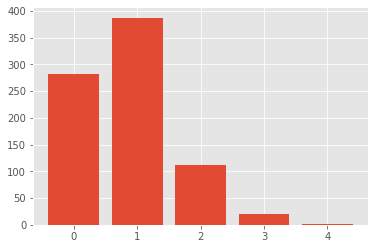

In [30]:
from matplotlib import pyplot as plt

counts = {}
for i in kaggle['Predict']:
    if i == '-1':
        if 0 in counts:
            counts[0] += 1
        else:
            counts[0] = 1
        continue

    num_author = len(i.split())
    if num_author in counts:
        counts[num_author] += 1
    else:
        counts[num_author] = 1

plt.bar(counts.keys(), counts.values())
plt.show()

delet some useless data: 100%|██████████| 25793/25793 [00:00<00:00, 32653.70it/s]


Number of instance with label :  7460
Number of instance without label(remain) :  1894


100%|██████████| 9354/9354 [00:02<00:00, 3405.39it/s]


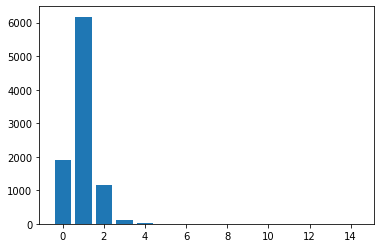

In [46]:
from preprocessing import for_train
X, y = for_train("year_venue", p=0.20250)

counts = {}
for i in tqdm(y):
    num_author = sum(i).item()
    if num_author in counts:
        counts[num_author] += 1
    else:
        counts[num_author] = 1

plt.bar(counts.keys(), counts.values())
plt.show()

In [73]:
kaggle

,Predict
ID,
0,1 10 92
1,1 2
2,31
3,6 23
4,-1
...,...
795,1 54
796,97
797,13 71


# Kaggle Predictions

- YEAR_VENUE_WEIGHT = 1/3
- COAUTHOR_WEIGHT = 1/3
- SENTENCE_WEIGHT = 1/3
    - f1 = 0.47230

# Kaggle Predictions - 2

- YEAR_VENUE_WEIGHT = 0.08884680485159918.
- COAUTHOR_WEIGHT = 0.5925861815691253
- SENTENCE_WEIGHT = 0.3185670135792754
    - f1 = 0.52080

In [22]:
print(YEAR_VENUE_WEIGHT)
print(COAUTHOR_WEIGHT)
print(SENTENCE_WEIGHT)

0.08346672643333612
0.586237115452411
0.3302961581142529


# Kaggle Predictions - Weighted

- YEAR_VENUE_WEIGHT = 0.08346672643333612
- COAUTHOR_WEIGHT = 0.586237115452411
- SENTENCE_WEIGHT = 0.3302961581142529
- THRESHOLD = 0.2
    - f1 = 0.54747

# Kaggle Predictions - 3

- YEAR_VENUE_WEIGHT = 0.09421771031395267.
- COAUTHOR_WEIGHT = 0.43393907367832263
- SENTENCE_WEIGHT = 0.4718432160077247
- THRESHOLD = 0.3
    - f1 = 0.53130